### Spawn objects along with `Panda`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass,get_env_object_names,\
    set_env_objects,put_env_objets_in_a_row,get_env_object_poses,quat2r
from util import get_colors,rpy2r
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Done.")

Done.


### Parse `Panda` with objects

In [2]:
env = MuJoCoParserClass(name='Panda',rel_xml_path='../asset/panda/franka_panda_w_objs.xml',VERBOSE=True)

[Panda] Instantiated from [/Users/sj/Dropbox/SJ/Research/Implementation/simple-mujoco-usage-v2/asset/panda/franka_panda_w_objs.xml]
- Simulation timestep is [0.0020]sec and frequency is [500]HZ
- [Panda] has [29] bodies and body names are
['world', 'panda_base', 'panda_pedestal', 'panda_link_0', 'panda_link_1', 'panda_link_2', 'panda_link_3', 'panda_link_4', 'panda_link_5', 'panda_link_6', 'panda_link_7', 'right_hand', 'panda_right_gripper', 'panda_eef', 'panda_leftfinger', 'panda_finger_joint1_tip', 'panda_rightfinger', 'panda_finger_joint2_tip', 'work_space', 'obj_box_01', 'obj_box_02', 'obj_box_03', 'obj_box_04', 'obj_box_05', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05']
- [Panda] has [19] joints
 [00] name:[panda_joint1] type:[revolute] joint range:[-2.90 to 2.90]
 [01] name:[panda_joint2] type:[revolute] joint range:[-1.76 to 1.76]
 [02] name:[panda_joint3] type:[revolute] joint range:[-2.90 to 2.90]
 [03] name:[panda_joint4] type:

### Initialize objects and plot

Creating window glfw
Creating offscreen glfw


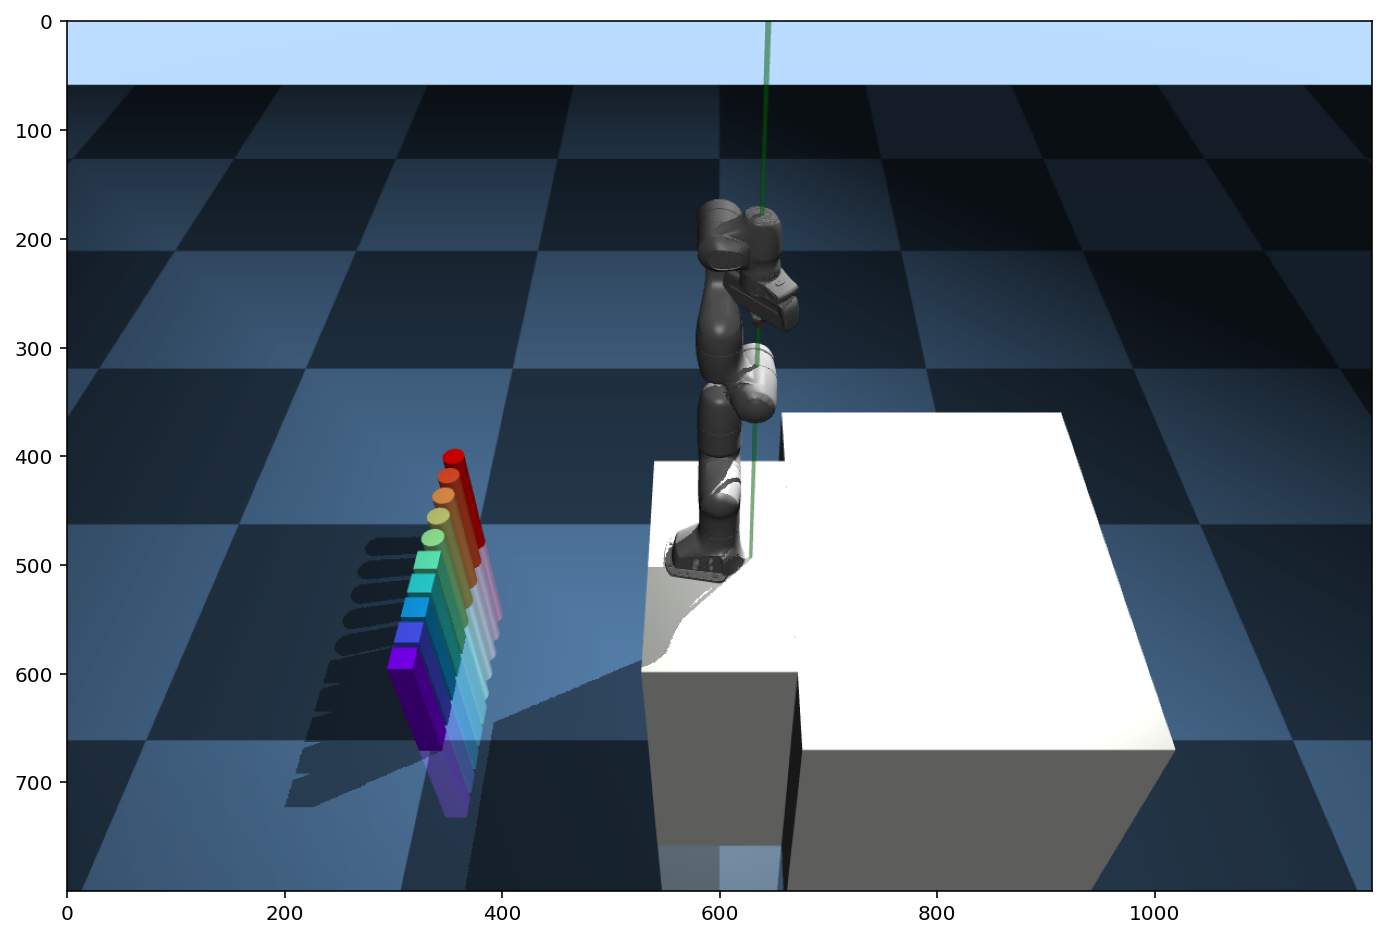

In [3]:
put_env_objets_in_a_row(env,prefix='obj_',x_obj=-1.0,z_obj=0.0)
env.init_viewer(TERMINATE_GLFW=False,INITIALIZE_GLFW=True,window_width=0.5,window_height=0.5)
env.plot_scene()

### Random spawn objects and run

In [ ]:
from scipy.spatial.distance import cdist

env.reset(RESET_SIM=True)
env.init_viewer(TERMINATE_GLFW=True,INITIALIZE_GLFW=True,window_width=0.5,window_height=0.5)
env.set_max_sec(max_sec=10)

# Objects random spawn
n_place         = 10 # number of objects to place
x_range         = [0.3,1.0]
y_range         = [-0.5,0.5]
z_range         = [1.01,1.01]
put_env_objets_in_a_row(env,prefix='obj_',x_obj=-1.0,z_obj=0.0) # init objects
object_names    = get_env_object_names(env,prefix='obj_')
n_object        = len(object_names)
object_idxs     = np.random.permutation(n_object)[:n_place].astype(int)
object_pos_list = np.zeros((n_place,3))
for o_idx in range(n_place):
    while True:
        x = np.random.uniform(low=x_range[0],high=x_range[1])
        y = np.random.uniform(low=y_range[0],high=y_range[1])
        z = np.random.uniform(low=z_range[0],high=z_range[1])
        xyz = np.array([x,y,z])
        if o_idx >= 1:
            devc = cdist(xyz.reshape((-1,3)),object_pos_list[:o_idx,:].reshape((-1,3)),'euclidean')
            if devc.min() > 0.15: break # minimum distance between objects
        else:
            break
    object_pos_list[o_idx,:] = xyz
object_placed_names = [object_names[object_idx] for object_idx in object_idxs]
set_env_objects(env,object_names=object_placed_names,object_pos_list=object_pos_list,colors=None)

# Simulate
OBJ_FALL = False
while env.IS_ALIVE():
    # Step
    if not OBJ_FALL: env.step()
    
    # Get object poses and check 
    object_xyzs,object_quats = get_env_object_poses(env,object_names=object_names)
    idxs_fall = [o_idx for o_idx in range(object_quats.shape[0]) if (quat2r(object_quats[o_idx,:])[2,2]<=0.8)]
    if len(idxs_fall) > 0: OBJ_FALL = True
        
    # Render
    marker_color = np.array([0.5,0.5,0.5,1.0])
    marker_xyzs  = np.array([[0.3,0,1],[0.3,0.5,1],[0.3,-0.5,1],[1,0,1],[1,0.5,1],[1,-0.5,1]])
    for m_idx in range(marker_xyzs.shape[0]): # plot markers
        marker_xyz = marker_xyzs[m_idx,:]
        env.add_marker(pos=marker_xyz,radius=0.03,color=marker_color,label='%s'%(marker_xyz))
    for o_idx in range(n_object): # plot objects
        object_xyz,object_quat = object_xyzs[o_idx,:],object_quats[o_idx]
        object_R = quat2r(object_quat) # rotation matrix
        env.add_marker(pos=object_xyz,radius=0.01,color=np.array([1,0,0,0.5]),
                       label='B[%d]'%(o_idx)) # red bottom of an object
        env.add_marker(pos=object_xyz+0.5*object_R[:,2],radius=0.01,color=np.array([0,0,0,0.5]),
                       label='T[%d]'%(o_idx)) # black top of an object
    env.render()
    
    # Printout fallen
    # if OBJ_FALL: print ("[%05d] Object(s):%s has/have been fallen."%(env.tick,idxs_fall))
print ("Done.")

Creating window glfw
Creating window glfw
